It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee7519ad50b558e6b8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


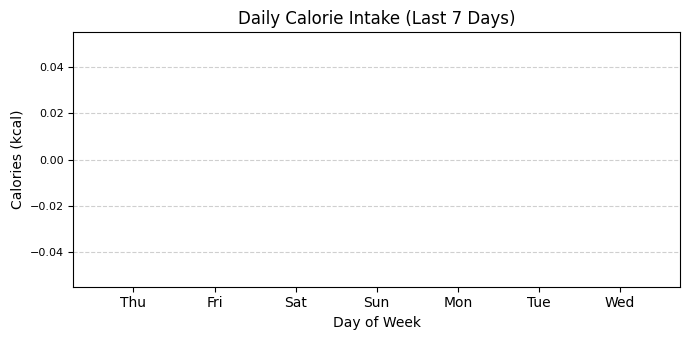

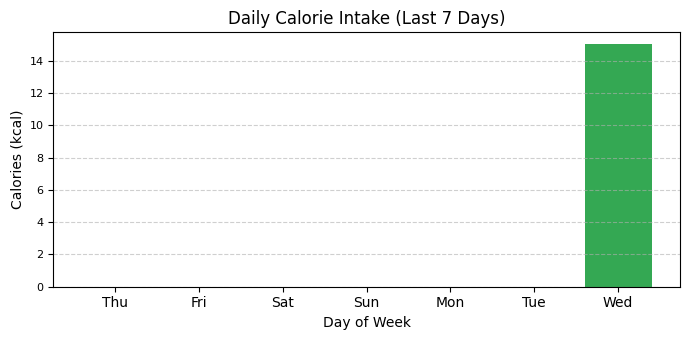

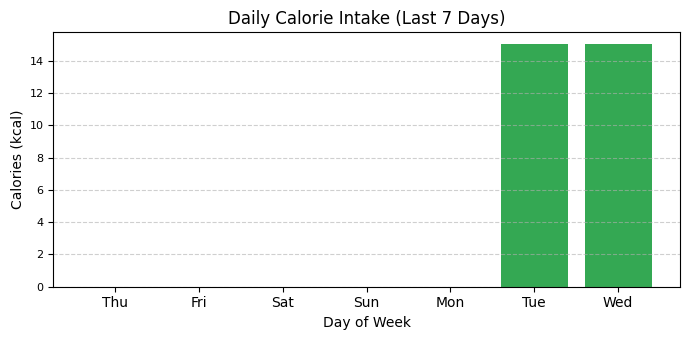

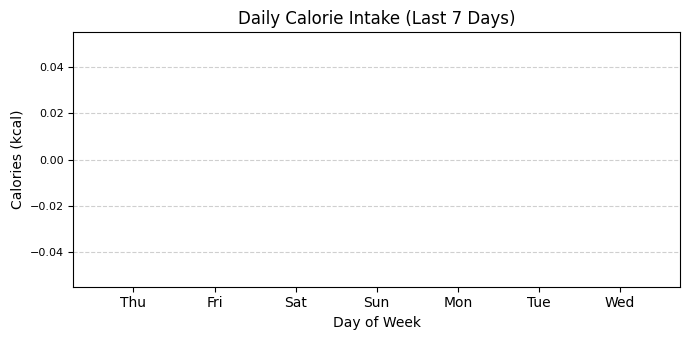

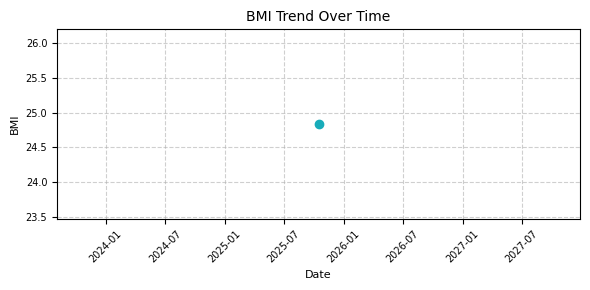

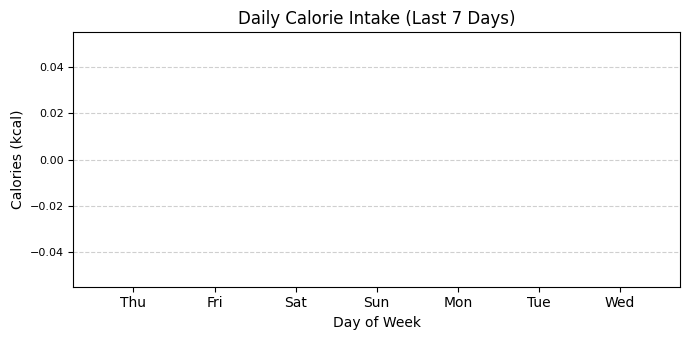

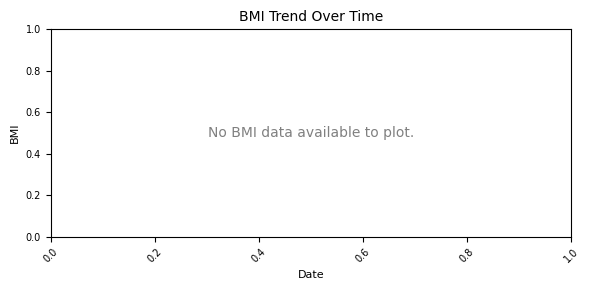

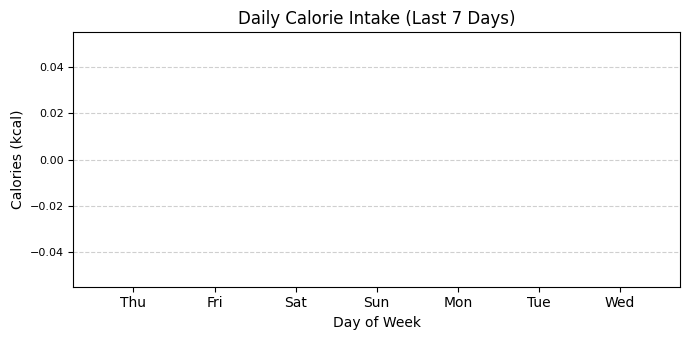

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import io
import base64

food_log = []

# --- Helper Functions for Image/Plotting ---

def plot_bmi_history(history_data):
    """
    Generates a plot of BMI over time using only the provided history_data.
    """
    actual_data = [entry for entry in history_data if entry.get('bmi', 0) > 0]

    if not actual_data:
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.set_title('BMI Trend Over Time', fontsize=10)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel('BMI', fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.text(0.5, 0.5, "No BMI data available to plot.",
                ha='center', va='center', transform=ax.transAxes, color='gray')
        plt.tight_layout()
        return fig

    dates = [entry['date'] for entry in actual_data]
    bmis = [entry['bmi'] for entry in actual_data]

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(dates, bmis, marker='o', color='#18acba')
    ax.set_title('BMI Trend Over Time', fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('BMI', fontsize=8)

    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    return fig


def plot_weekly_calories(food_log):
    """Generates a plot of total calories consumed per day over the last 7 days and returns the Matplotlib Figure."""

    # 1. Determine the date range and create a dictionary for daily totals
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=6)
    date_range = [start_date + timedelta(days=i) for i in range(7)]

    # Initialize totals for the last 7 days
    daily_calories = {date.strftime('%Y-%m-%d'): 0 for date in date_range}

    # 2. Aggregate calories by day within the last 7-day window
    for entry in food_log:
        entry_date = entry['timestamp'].date()
        entry_date_str = entry_date.strftime('%Y-%m-%d')

        if start_date <= entry_date <= end_date:
            daily_calories[entry_date_str] += entry['calories']

    # 3. Prepare data for plotting
    sorted_dates_str = sorted(daily_calories.keys())
    dates_labels = [datetime.strptime(date_str, '%Y-%m-%d').strftime('%a') for date_str in sorted_dates_str]
    calorie_totals = [daily_calories[date_str] for date_str in sorted_dates_str]

    # 4. Create the plot
    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.bar(dates_labels, calorie_totals, color='#34A853')
    ax.set_title('Daily Calorie Intake (Last 7 Days)', fontsize=12)
    ax.set_xlabel('Day of Week', fontsize=10)
    ax.set_ylabel('Calories (kcal)', fontsize=10)

    ax.tick_params(axis='x', rotation=0, labelsize=10)

    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    return fig


# --- BMI & Metabolic Rate Functions ---

def calculate_bmi(unit_system, weight, height):
    """Calculates BMI and returns the result, category, and plot."""
    if not weight or not height or weight <= 0 or height <= 0:
        return "Please enter valid weight and height.", "", plot_bmi_history([{'date': datetime.now(), 'bmi': 0}])

    if unit_system == "Imperial (lb, in)":
        weight_kg = weight * 0.453592
        height_cm = height * 2.54
    else:
        weight_kg = weight
        height_cm = height

    height_m = height_cm / 100
    bmi = weight_kg / (height_m ** 2)

    category = ""
    if bmi < 18.5:
        category = "Underweight"
    elif 18.5 <= bmi < 25:
        category = "Normal weight"
    elif 25 <= bmi < 30:
        category = "Overweight"
    else:
        category = "Obesity"

    plot_fig = plot_bmi_history([{'date': datetime.now(), 'bmi': bmi}])

    return f"Your BMI is: {bmi:.2f}", f"Category: {category}", plot_fig

def calculate_metabolic_rate(age, gender, weight, height, activity_level):
    """
    Calculates BMR, TDEE (Estimated daily caloric needs),
    and caloric goals for weight change using the Mifflin-St Jeor formula.
    """
    if not age or not weight or not height or weight <= 0 or height <= 0 or age <= 0:
        return "Please enter valid age, weight, and height.", 0

    if gender == "male":
        bmr = (10 * weight) + (6.25 * height) - (5 * age) + 5
    else:
        bmr = (10 * weight) + (6.25 * height) - (5 * age) - 161

    tdee = bmr * activity_level

    weight_loss = tdee - 500
    weight_gain = tdee + 500

    result_text = (
        f"**Your Basal Metabolic Rate (BMR) is:** {bmr:.2f} kcal/day.\n"
        f"**Your Total Daily Energy Expenditure (TDEE) is:** {tdee:.2f} kcal/day.\n\n"
        f"**Calorie Goals (approx.):**\n"
        f"  - **Maintain Weight:** {tdee:.0f} kcal/day\n"
        f"  - **Lose 0.5kg/week:** {weight_loss:.0f} kcal/day\n"
        f"  - **Gain 0.5kg/week:** {weight_gain:.0f} kcal/day"
    )

    return result_text, tdee

# --- Food Tracker Functions ---

def add_food_entry(food_item, calories, date_of_entry, tdee_input):
    """Adds a food entry with a specified date and returns the updated log, total calories, and plot."""
    global food_log

    if not food_item or not calories or calories < 0:
        return "Please enter a valid food item and calorie count.", [], "**Total Calories Today:** 0 kcal", "", plot_weekly_calories(food_log)

    try:
        entry_datetime = date_of_entry

    except Exception:
        entry_datetime = datetime.now()


    food_log.append({"item": food_item, "calories": calories, "timestamp": entry_datetime})

    log_output = [[entry['item'], entry['calories'], entry['timestamp'].strftime('%Y-%m-%d %H:%M')] for entry in food_log]

    today_date = datetime.now().date()
    # Check calories only for entries made today (based on the entry's date, not the user-selected date)
    total_calories_today = sum(entry['calories'] for entry in food_log if entry['timestamp'].date() == today_date)

    tdee_comparison = ""
    if tdee_input and tdee_input > 0:
        remaining = tdee_input - total_calories_today
        tdee_comparison = f"TDEE ({tdee_input:.0f} kcal): "
        if remaining > 0:
            tdee_comparison += f"You have **{remaining:.0f} kcal** remaining for today."
        else:
            tdee_comparison += f"You are **{abs(remaining):.0f} kcal** over your TDEE limit today."

    plot_fig = plot_weekly_calories(food_log)

    return "Food added!", log_output, f"**Total Calories Today:** {total_calories_today} kcal", tdee_comparison, plot_fig

def clear_food_log():
    """Clears the food log."""
    global food_log
    food_log = []
    plot_fig = plot_weekly_calories(food_log)
    return "Log cleared!", [], "**Total Calories Today:** 0 kcal", "", plot_fig

custom_theme = gr.themes.Soft(
    primary_hue="cyan",
).set(
    button_primary_background_fill="#77c2c7",
    button_primary_background_fill_hover="#18acba",
    button_secondary_background_fill="white",
    button_secondary_background_fill_hover="#e8f9fa",
    block_background_fill="white",
    block_border_width="1px",
    block_border_color="#d5eced",
    block_shadow="0 1px 3px 0 rgb(0 0 0 / 0.1), 0 1px 2px -1px rgb(0 0 0 / 0.1)",
    body_background_fill="#f0f2f5",
)

with gr.Blocks(title="BME Health Calculator Suite", theme=custom_theme, css="""
    .main-container {
        max-width: 800px;
        margin: 0 auto;
        padding: 0;
    }
    .header-section {
        background-color: #a8e1e6;
        padding: 20px;
        text-align: center;
        color: white;
        border-radius: 8px 8px 0 0;
    }
    .header-section h1 {
        font-size: 2em;
        margin-bottom: 5px;
        display: flex;
        align-items: center;
        justify-content: center;
        gap: 10px;
    }
    .header-section h1 img {
        height: 40px;
        vertical-align: middle;
    }
    .header-section p {
        font-size: 1.1em;
        margin: 0;
    }
    .gradio-tabs {
        border-radius: 8px;
        background-color: transparent;
        border: none;
        box-shadow: none;
        margin-top: 20px;
    }
    .gradio-tabs > div[role="tablist"] {
        justify-content: center;
    }
    .gradio-tabs > div[role="tablist"] > button {
        background-color: transparent !important;
        color: #18afba !important;
        font-size: 1.1em;
        font-weight: bold;
        border: none !important;
        border-bottom: 2px solid transparent !important;
        padding: 15px 30px;
        position: relative;
    }
    .gradio-tabs > div[role="tablist"] > button.selected {
        background-color: transparent !important;
        color: #18afba !important;
        border-bottom-color: #18afba !important;
    }
    .gradio-tabs .gradio-tab-content {
        padding: 20px;
        background-color: white;
        border-radius: 8px;
        box-shadow: 0 1px 3px 0 rgb(0 0 0 / 0.1), 0 1px 2px -1px rgb(0 0 0 / 0.1);
        margin-top: 20px;
    }
""") as demo:
    gr.Markdown(f"""
    <div class="header-section">
        <h1>
            BME Health Calculator Suite
        </h1>
        <p>A comprehensive health tracking application for Biomedical Engineering students</p>
    </div>
    """)

    with gr.Tabs(elem_classes=["gradio-tabs"]):
        # BMI Calculator Tab
        with gr.Tab("📊 BMI Calculator"):
            with gr.Group(elem_classes=["gradio-tab-content"]):
                gr.Markdown("### <font color='#34A853'>**Body Mass Index Calculator**</font>")
                gr.Markdown("Calculate your BMI and see where you fall on the health categories.")

                bmi_unit_system = gr.Dropdown(
                    label="Unit System:",
                    choices=["Metric (cm, kg)", "Imperial (lb, in)"],
                    value="Metric (cm, kg)"
                )

                bmi_height_input = gr.Number(label="Height (cm):", placeholder="e.g., 170")
                bmi_weight_input = gr.Number(label="Weight (kg):", placeholder="e.g., 70")

                bmi_calculate_btn = gr.Button("Calculate BMI", variant="primary")

                with gr.Column():
                    bmi_result_output = gr.Label(label="Your BMI")
                    bmi_category_output = gr.Label(label="Category")

                bmi_plot_output = gr.Plot(
                    value=plot_bmi_history([{'date': datetime.now(), 'bmi': 0}]),
                    label="BMI Trend Over Time"
                )

                bmi_calculate_btn.click(
                    fn=calculate_bmi,
                    inputs=[bmi_unit_system, bmi_weight_input, bmi_height_input],
                    outputs=[bmi_result_output, bmi_category_output, bmi_plot_output]
                )

        # Metabolic Rate Calculator Tab
        with gr.Tab("🔥 Metabolic Rate"):
            with gr.Group(elem_classes=["gradio-tab-content"]):
                gr.Markdown("### <font color='#2c888f'>**Metabolic Rate Calculator**</font>")
                gr.Markdown("Calculate your estimated daily calorie needs and goals.")
                with gr.Row():
                    mr_age_input = gr.Number(label="Age")
                    mr_gender_input = gr.Radio(["male", "female"], label="Gender")
                with gr.Row():
                    mr_weight_input = gr.Number(label="Weight (kg)")
                    mr_height_input = gr.Number(label="Height (cm)")

                activity_levels = [1.2, 1.375, 1.55, 1.725, 1.9]
                activity_labels = ["Sedentary (Little or no exercise)", "Lightly Active (1-3 days/week)", "Moderately Active (3-5 days/week)", "Very Active (6-7 days/week)", "Extra Active (Daily, physically demanding job)"]
                mr_activity_input = gr.Radio(
                    label="Activity Level",
                    choices=activity_labels,
                    value=activity_labels[0]
                )

                mr_calculate_btn = gr.Button("Calculate Calories & Goals", variant="primary")

                mr_result_output = gr.Markdown(label="Metabolic Rate and Daily Calories", value="Your BMR and TDEE will appear here.")

                tdee_value_output = gr.Number(label="TDEE Value (kcal)", visible=False)


                def get_calories(age, gender, weight, height, activity_label):
                    activity_multiplier = activity_levels[activity_labels.index(activity_label)]
                    return calculate_metabolic_rate(age, gender, weight, height, activity_multiplier)

                mr_calculate_btn.click(
                    fn=get_calories,
                    inputs=[mr_age_input, mr_gender_input, mr_weight_input, mr_height_input, mr_activity_input],
                    outputs=[mr_result_output, tdee_value_output]
                )

        # Food Tracker Tab
        with gr.Tab("🍎 Food Tracker"):
            with gr.Group(elem_classes=["gradio-tab-content"]):
                gr.Markdown("### <font color='#34A853'>**Food Tracker**</font>")
                gr.Markdown("Track your daily calorie intake.")

                tdee_input_tracker = gr.Number(
                    label="Enter Your Daily Calorie Goal (TDEE):",
                    placeholder="e.g., 2000 (from Metabolic Rate tab)",
                    value=2000.0
                )

                with gr.Row():
                    food_date_input = gr.DateTime(
                        label="Date and Time of Meal",
                        value=datetime.now(),
                        type="datetime"
                    )
                    food_item_input = gr.Textbox(label="Food Item", placeholder="e.g. Apple, Chicken breast")
                    food_calories_input = gr.Number(label="Calories (kcal)", placeholder="e.g. 95")

                add_food_btn = gr.Button("Add Food Entry", variant="primary")

                tdee_comparison_output = gr.Markdown(label="Calorie Goal Comparison")


                with gr.Column():
                    food_log_list = gr.DataFrame(headers=["Food Item", "Calories", "Time Added"], type="array", value=[], row_count=5)
                    total_calories_label = gr.Markdown(label="Total Calories", value="**Total Calories Today:** 0 kcal")

                calorie_plot_output = gr.Plot(
                    value=plot_weekly_calories([]),
                    label="Daily Calorie Intake (Recent Week)"
                )

                add_food_btn.click(
                    fn=add_food_entry,
                    inputs=[food_item_input, food_calories_input, food_date_input, tdee_input_tracker],
                    outputs=[gr.Textbox(visible=False), food_log_list, total_calories_label, tdee_comparison_output, calorie_plot_output]
                )

                clear_log_btn = gr.Button("Clear Log", variant="secondary")
                clear_log_btn.click(
                    fn=clear_food_log,
                    inputs=[],
                    outputs=[gr.Textbox(visible=False), food_log_list, total_calories_label, tdee_comparison_output, calorie_plot_output]
                )

demo.launch()